In [36]:
import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt

package_dir = '../src'
package_dir = os.path.dirname(package_dir)
if package_dir not in sys.path:
    sys.path.append(package_dir)

from src.sentinel2_handling.sentinel2_downloader import query_sentinel2, filter_item_list
import src.utils.img_utils as iu
import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Intro: 
Punggol has changed dramatically over the years.. Using Sentinel2 data, I would like to visualize and explore the changes.

# Data Loading from Sentinel2

In [59]:
ns_bounds = [1.4234,1.3831] #lat
ew_bounds = [103.9323,103.8853] #long
bbox = [ew_bounds[1],ns_bounds[1],ew_bounds[0],ns_bounds[0]]

In [60]:
items = query_sentinel2(bbox=bbox, max_cloud_cover=85, num_days_before_end=1500)

In [61]:
filt_metadata, filt_item_procs = filter_item_list(items, bbox=bbox, min_usable_pct=80)

List filtered as 32 out of 184 items orginally


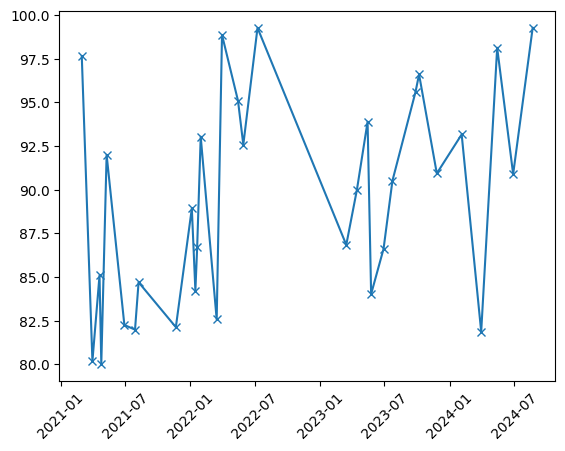

In [63]:
plt.figure()
x = [] 
y = []
for m in filt_metadata:
    x.append(dt.strptime(m[0], "%Y-%m-%d"))
    y.append(m[-1])
plt.plot(x,y,'-x')
plt.xticks(rotation=45);

In [64]:
num_days_between_shots = []
date_format = "%Y-%m-%d"
for n in range(1,len(filt_metadata)):
    start_date = dt.strptime(filt_metadata[n-1][0],"%Y-%m-%d")
    end_date = dt.strptime(filt_metadata[n][0],"%Y-%m-%d")
    num_days_between_shots.append((end_date-start_date).days + 1)

print(num_days_between_shots)

[31, 21, 6, 16, 51, 31, 11, 106, 46, 11, 6, 11, 46, 16, 46, 16, 41, 251, 31, 31, 11, 36, 26, 66, 11, 51, 71, 56, 46, 46, 56]


In [71]:
num_items = len(filt_metadata)
for i in range(int(num_items/5)):
    s = ""
    for k in range(5):
        ind = 5*i + k
        if ind >= num_items:
            break
        s += f"({filt_metadata[ind][0]}, {filt_metadata[ind][-1]:.3f}),\t"
    print(s[:-2])

(2021-03-01, 97.654),	(2021-03-31, 80.182),	(2021-04-20, 85.091),	(2021-04-25, 80.029),	(2021-05-10, 91.998)
(2021-06-29, 82.254),	(2021-07-29, 81.986),	(2021-08-08, 84.702),	(2021-11-21, 82.129),	(2022-01-05, 88.931)
(2022-01-15, 84.218),	(2022-01-20, 86.692),	(2022-01-30, 93.040),	(2022-03-16, 82.569),	(2022-03-31, 98.866)
(2022-05-15, 95.100),	(2022-05-30, 92.578),	(2022-07-09, 99.270),	(2023-03-16, 86.842),	(2023-04-15, 89.998)
(2023-05-15, 93.894),	(2023-05-25, 84.025),	(2023-06-29, 86.614),	(2023-07-24, 90.513),	(2023-09-27, 95.598)
(2023-10-07, 96.604),	(2023-11-26, 90.932),	(2024-02-04, 93.164),	(2024-03-30, 81.867),	(2024-05-14, 98.130)


We want to get the highest usable percentage if there are multiple usable images per month

In [74]:
df = pd.DataFrame(filt_metadata, columns=["date","eo_cloud_cover","usable_pixels"])

In [76]:
df['year-month'] = df['date'].str[:7]

In [80]:
max_usable_pixs_per_month = df.groupby('year-month').agg({'usable_pixels':'max'}).to_dict()['usable_pixels']
df['is_best'] = df['usable_pixels'] == df['year-month'].map(max_usable_pixs_per_month)
print(f"need to drop {np.sum(~df['is_best'])} out of {len(df)} images")

In [97]:
inds_to_keep = set(df[df['is_best']].index)

good_metadata = []
good_processors = []
for ii in range(num_items):
    if ii not in inds_to_keep:
        continue
    good_metadata.append(filt_metadata[ii])
    good_processors.append(filt_item_procs[ii])
    
print(len(good_metadata))

24


In [98]:
#compute indices:
[ip.load_and_compute_spectral_indices() for ip in good_processors];

# RGB composite timelapse

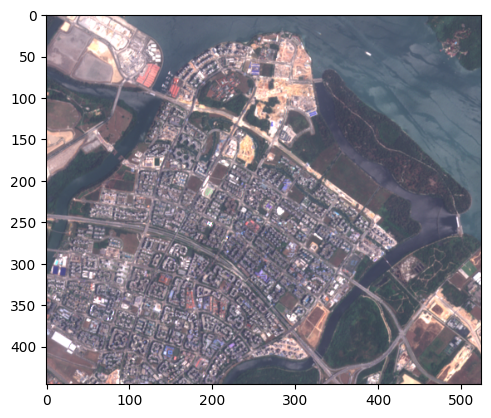

In [106]:
plt.figure()
nimg = iu.normalize_image(good_processors[0].spectral_indices.rgb_image.img)
nimg = iu.adjust_contrast_brightness(nimg, contrast=5, brightness=0.2)
nimg[:,:,2] = np.clip(nimg[:,:,2]*1.08+ 0.08,0,1)
# nimg[:,:,1] = np.clip(nimg[:,:,1]*1.05,0,1)
# nimg[:,:,0] = np.clip(nimg[:,:,0]+0.02,0,1)
plt.imshow(nimg)

In [107]:
# test histogram normalization
ref_image = iu.normalize_image(good_processors[0].spectral_indices.rgb_image.img)
ref_image = iu.adjust_contrast_brightness(ref_image, contrast=5, brightness=0.2)
ref_image[:,:,2] = np.clip(ref_image[:,:,2]*1.08+ 0.08,0,1)

In [108]:
test_img = iu.normalize_image(good_processors[3].spectral_indices.rgb_image.img)
matched_img = iu.match_images(ref_img=ref_image, src_img=test_img)

Text(0.5, 1.0, 'matched')

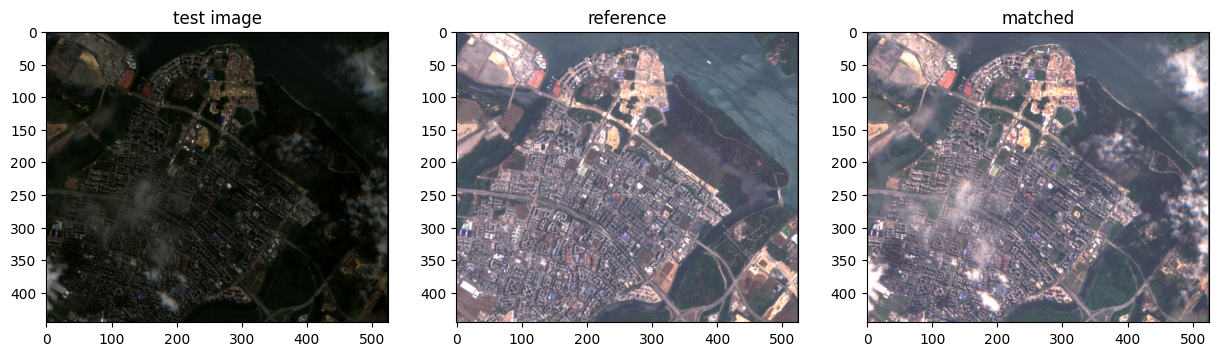

In [109]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(test_img)
plt.title("test image")
plt.subplot(1,3,2)
plt.imshow(ref_image)
plt.title('reference')
plt.subplot(1,3,3)
plt.imshow(matched_img)
plt.title("matched")

In [122]:
all_images = [iu.normalize_image(proc.spectral_indices.rgb_image.img) for proc in good_processors]
matched_images = [iu.match_images(ref_img=ref_image, src_img=img) for img in all_images]
imgs_uint8 = [iu.convert_to_uint8(img) for img in matched_images]

Text(0.5, 1.0, 'matched (uint8)')

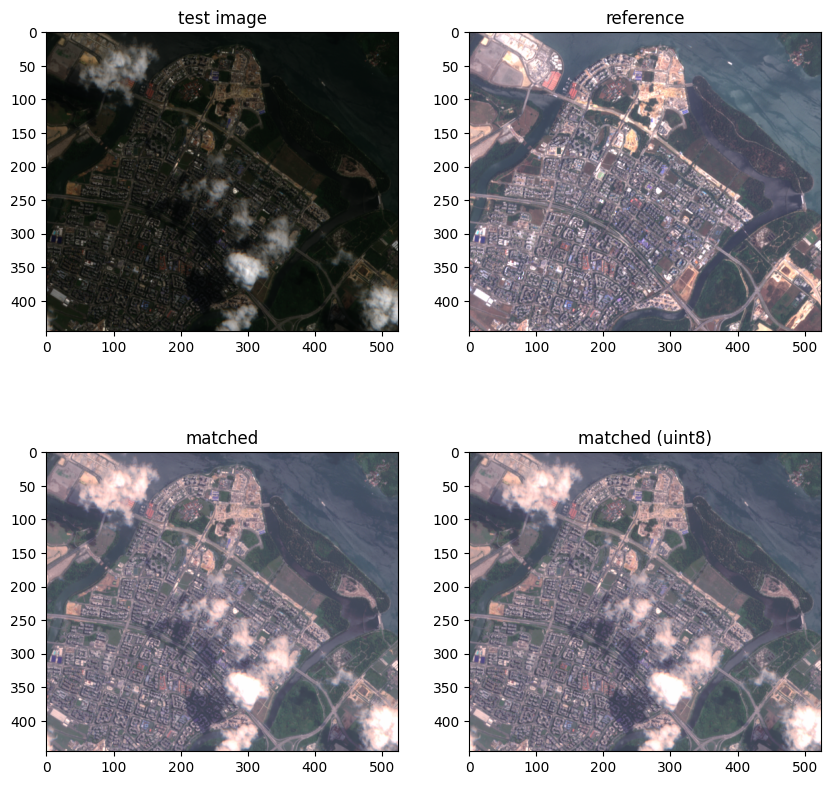

In [123]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(all_images[5])
plt.title("test image")
plt.subplot(2,2,2)
plt.imshow(ref_image)
plt.title('reference')
plt.subplot(2,2,3)
plt.imshow(matched_images[5])
plt.title("matched")
plt.subplot(2,2,4)
plt.imshow(imgs_uint8[5])
plt.title("matched (uint8)")

## output to gif \o/

In [124]:
nice_font = "../src/utils/MesloLGS NF Bold.ttf"